## Import Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [2]:
spark = SparkSession.builder.getOrCreate()

# Importing Dataset

In [3]:
df = spark.read.csv("./Clustering.csv", header=True,\
                   inferSchema=True)

df.show()

+---------------+-----------------+--------------+-------------------+--------+--------------+---------------+
|Trash Pollution|Oil Concentration|Bacteria Level|Algae Concentration|Humidity|Wind Direction|Air Temperature|
+---------------+-----------------+--------------+-------------------+--------+--------------+---------------+
|            Low|             2.22|           207|               6.05|      52|           280|             38|
|           High|             1.37|           133|               4.21|      60|            30|           null|
|         Medium|             0.65|            84|               8.07|      18|           164|             12|
|           null|             2.62|           276|               6.53|      93|           254|             29|
|            Low|             1.68|           126|               1.73|      52|           176|             18|
|           High|             1.03|           308|              10.51|      95|           256|             12|
|

## Preprocessing Data

In [4]:
# 1. Pilih colomn yang relevan
select_df = df.select(["Trash Pollution", "Bacteria Level", "Oil Concentration",\
                     "Algae Concentration"])
# 2. Drop Missing Value atau Null
no_null_df = select_df.dropna()
no_null_df.show()

+---------------+--------------+-----------------+-------------------+
|Trash Pollution|Bacteria Level|Oil Concentration|Algae Concentration|
+---------------+--------------+-----------------+-------------------+
|            Low|           207|             2.22|               6.05|
|           High|           133|             1.37|               4.21|
|         Medium|            84|             0.65|               8.07|
|            Low|           126|             1.68|               1.73|
|           High|           308|             1.03|              10.51|
|         Medium|           181|             0.56|               7.27|
|            Low|            64|             1.23|               2.01|
|         Medium|            92|             0.27|               1.15|
|           High|           270|             3.58|               9.88|
|            Low|           198|             1.65|               4.12|
|         Medium|            54|             0.57|               1.64|
|     

In [5]:
# 3. Encode value ke binary

encoded_df = no_null_df.withColumn("Trash Pollution",\
                                  when(df["Trash Pollution"] == "Low", 0)\
                                   .when(df["Trash Pollution"] == "Medium", 1)\
                                   .when(df["Trash Pollution"] == "High", 2)
                                  )
encoded_df.show()

+---------------+--------------+-----------------+-------------------+
|Trash Pollution|Bacteria Level|Oil Concentration|Algae Concentration|
+---------------+--------------+-----------------+-------------------+
|              0|           207|             2.22|               6.05|
|              2|           133|             1.37|               4.21|
|              1|            84|             0.65|               8.07|
|              0|           126|             1.68|               1.73|
|              2|           308|             1.03|              10.51|
|              1|           181|             0.56|               7.27|
|              0|            64|             1.23|               2.01|
|              1|            92|             0.27|               1.15|
|              2|           270|             3.58|               9.88|
|              0|           198|             1.65|               4.12|
|              1|            54|             0.57|               1.64|
|     

In [6]:
# 4. Vectorize Data
vector_df = VectorAssembler(inputCols=encoded_df.columns,\
                           outputCol="vector").transform(encoded_df)
vector_df.show()

+---------------+--------------+-----------------+-------------------+--------------------+
|Trash Pollution|Bacteria Level|Oil Concentration|Algae Concentration|              vector|
+---------------+--------------+-----------------+-------------------+--------------------+
|              0|           207|             2.22|               6.05|[0.0,207.0,2.22,6...|
|              2|           133|             1.37|               4.21|[2.0,133.0,1.37,4...|
|              1|            84|             0.65|               8.07|[1.0,84.0,0.65,8.07]|
|              0|           126|             1.68|               1.73|[0.0,126.0,1.68,1...|
|              2|           308|             1.03|              10.51|[2.0,308.0,1.03,1...|
|              1|           181|             0.56|               7.27|[1.0,181.0,0.56,7...|
|              0|            64|             1.23|               2.01|[0.0,64.0,1.23,2.01]|
|              1|            92|             0.27|               1.15|[1.0,92.0,

In [7]:
# 5. Scaling Data
feat_df = StandardScaler(inputCol="vector", outputCol="features").fit(vector_df).transform(vector_df)

feat_df.show()

+---------------+--------------+-----------------+-------------------+--------------------+--------------------+
|Trash Pollution|Bacteria Level|Oil Concentration|Algae Concentration|              vector|            features|
+---------------+--------------+-----------------+-------------------+--------------------+--------------------+
|              0|           207|             2.22|               6.05|[0.0,207.0,2.22,6...|[0.0,1.8847302908...|
|              2|           133|             1.37|               4.21|[2.0,133.0,1.37,4...|[2.58653120876663...|
|              1|            84|             0.65|               8.07|[1.0,84.0,0.65,8.07]|[1.29326560438331...|
|              0|           126|             1.68|               1.73|[0.0,126.0,1.68,1...|[0.0,1.1472271335...|
|              2|           308|             1.03|              10.51|[2.0,308.0,1.03,1...|[2.58653120876663...|
|              1|           181|             0.56|               7.27|[1.0,181.0,0.56,7...|[1.29

## Clustering Model

In [8]:
kmeans = KMeans(featuresCol="features", k=2) # bisa diganti k=n, n nya bisa angka berapa aja
model = kmeans.fit(feat_df) # Nyesuai sama dataframe

In [9]:
clusters = model.transform(feat_df)
clusters.show()

# column prediction -> kluster mana

+---------------+--------------+-----------------+-------------------+--------------------+--------------------+----------+
|Trash Pollution|Bacteria Level|Oil Concentration|Algae Concentration|              vector|            features|prediction|
+---------------+--------------+-----------------+-------------------+--------------------+--------------------+----------+
|              0|           207|             2.22|               6.05|[0.0,207.0,2.22,6...|[0.0,1.8847302908...|         0|
|              2|           133|             1.37|               4.21|[2.0,133.0,1.37,4...|[2.58653120876663...|         0|
|              1|            84|             0.65|               8.07|[1.0,84.0,0.65,8.07]|[1.29326560438331...|         0|
|              0|           126|             1.68|               1.73|[0.0,126.0,1.68,1...|[0.0,1.1472271335...|         0|
|              2|           308|             1.03|              10.51|[2.0,308.0,1.03,1...|[2.58653120876663...|         1|
|       

In [10]:
# Silhouette score -> seberapa padat cluster-cluster
# -1 - 1
# -1 -> cluster ga padat dan hasil model jelek
# 1 -> cluster itu padat, data yang di assign cluster lumayan sesuai
eva = ClusteringEvaluator(featuresCol="features",\
                         predictionCol="prediction",\
                         metricName="silhouette",\
                         distanceMeasure="squaredEuclidean")

silhouette = eva.evaluate(clusters)
print(f"silhouette score: {silhouette}")

silhouette score: 0.4142365870638819


## Visualization

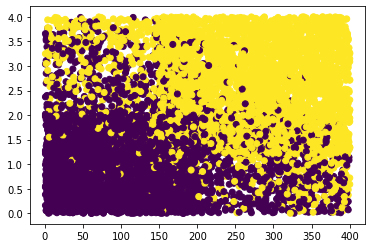

In [12]:
import matplotlib.pyplot as plt

resultPandas = clusters.toPandas()

plt.scatter(resultPandas["Bacteria Level"], \
           resultPandas["Oil Concentration"],\
           c=resultPandas["prediction"])
plt.show()